In [1]:
import os
import sys
import torch
from random import randint
from tqdm import tqdm
from utils.general_utils import safe_normalize

from argparse import ArgumentParser, Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams

from scene import Scene, GaussianModel
from pbr import CubemapLight, get_brdf_lut


from gaussian_renderer import pbr_render, network_gui, render, pbr_render_gshader


from gaussian_renderer import pbr_render_gshader


In [2]:
import matplotlib.pyplot as plt
import numpy as np
def show_rgb_image(tensor):
    # 将张量从 CUDA 转移到 CPU，并将其转换为 NumPy 数组
    img = tensor.detach().cpu().numpy().transpose(1, 2, 0)  # 变更维度顺序从 [C, H, W] 到 [H, W, C]
    plt.imshow(img)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

def show_single_channel_image(tensor):
    # 将张量从 CUDA 转移到 CPU，并将其转换为 NumPy 数组
    img = tensor.detach().cpu().numpy().squeeze(0)  # 移除通道维度 [1, H, W] -> [H, W]
    plt.imshow(img, cmap='gray')  # 使用灰度色图
    plt.axis('off')  # 不显示坐标轴
    plt.show()


In [5]:
import sys
from argparse import ArgumentParser

# 模拟命令行参数
sys.argv = ['pbr_train.py', '--source_path', '../data/ref_synthetic/toaster', '--model_path', './all_test/test_toaster/']

parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--save_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=[30_000])
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--start_checkpoint", type=str, default = None)
# parser.add_argument('--source_path', type=str, required=True)
# parser.add_argument('--model_path', type=str, required=True)
# --white_background 
# parser.add_argument('--white_background', action='store_true', default=False)
# # --eval 
# parser.add_argument('--eval', action='store_true', default=False)
# # --resolution
# parser.add_argument('--resolution', type=int, default=1)

# 解析参数
args = parser.parse_args()

# 现在可以像在脚本中一样访问 args
print(args)

pipe = pp.extract(args)
opt = op.extract(args)
dataset = lp.extract(args)

Namespace(checkpoint_iterations=[30000], compute_cov3D_python=False, convert_SHs_python=False, data_device='cuda', debug=False, densification_interval=100, densify_from_iter=500, densify_grad_threshold=0.0002, densify_until_iter=15000, depth_ratio=0.0, detect_anomaly=False, eval=False, feature_lr=0.0025, fix_brdf_lr=0, images='images', ip='127.0.0.1', iterations=30000, lambda_dist=1000.0, lambda_dssim=0.2, lambda_normal=0.05, light_lr_delay_mult=0.01, light_lr_final=0.0016, light_lr_init=0.016, light_lr_max_steps=30000, model_path='./all_test/test_toaster/', opacity_cull=0.05, opacity_lr=0.05, opacity_reset_interval=3000, percent_dense=0.01, port=6009, position_lr_delay_mult=0.01, position_lr_final=1.6e-06, position_lr_init=0.00016, position_lr_max_steps=30000, quiet=False, render_items=['RGB', 'Alpha', 'Normal', 'Depth', 'Edge', 'Curvature'], resolution=-1, rotation_lr=0.001, roughness_lr=0.0002, save_iterations=[7000, 30000], scaling_lr=0.005, sh_degree=3, source_path='../data/ref_sy

In [6]:
chkp_path = "/root/autodl-tmp/2dgsPBR/all_test/test_toaster/chkpnt30000.pth"
lp._source_path = "../data/ref_synthetic/toaster/"
lp._model_path = "../all_test/test_toaster/"

(model_params, light_params, _, first_iter) = torch.load(chkp_path)

gaussians = GaussianModel(lp.sh_degree)
scene = Scene(dataset, gaussians, shuffle=False)
gaussians.restore(model_params)

cubemap = CubemapLight(base_res=256).cuda()
cubemap.load_state_dict(light_params)
cubemap.eval()

print("Restored from checkpoint at iteration", first_iter)

bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")


Found transforms_train.json file, assuming Blender data set!
Reading Training Transforms


Reading Test Transforms
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  100000
Restored from checkpoint at iteration 30000


In [7]:
viewpoint_stack = scene.getTrainCameras().copy()
# viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
viewpoint_cam = viewpoint_stack[80]
brdf_lut = get_brdf_lut().cuda()
cubemap.build_mips()

Using /root/.cache/torch_extensions/py38_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py38_cu118/renderutils_plugin/build.ninja...
Building extension module renderutils_plugin...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module renderutils_plugin...


In [8]:
import torch.nn.functional as F
canonical_rays = scene.get_canonical_rays()
canonical_rays.shape, canonical_rays
H, W = viewpoint_cam.image_height, viewpoint_cam.image_width
c2w = torch.inverse(viewpoint_cam.world_view_transform.T)  # [4, 4]
view_dirs = -(
    (
        F.normalize(canonical_rays[:, None, :], p=2, dim=-1)
        * c2w[None, :3, :3]
    )  # [HW, 3, 3]
    .sum(dim=-1)
    .reshape(H, W, 3)
)
# canonical_rays是由相机中心指向外部的，所以取负号是wo的方向
# view_dirs.shape, torch.norm(view_dirs,dim=-1)

In [13]:
import importlib
import gaussian_renderer
importlib.reload(gaussian_renderer)
from gaussian_renderer import pbr_render_deffered

In [14]:
render_pkg = pbr_render_deffered(viewpoint_camera=viewpoint_cam,
                                             pc=gaussians,
                                             light=cubemap,
                                             pipe=pipe,
                                             bg_color=background,
                                             view_dirs=view_dirs,
                                             brdf_lut=brdf_lut,
                                             speed=False)
render_pkg.keys()

dict_keys(['render', 'viewspace_points', 'visibility_filter', 'radii', 'rend_alpha', 'rend_normal', 'rend_dist', 'surf_depth', 'surf_normal', 'kd_map', 'ks_map', 'kr_map', 'cr_map', 'specular_color', 'diffuse_color'])

In [15]:
image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]
alpha, rend_normal, dist, surf_depth, normal_from_d = render_pkg["rend_alpha"], render_pkg["rend_normal"], render_pkg["rend_dist"], render_pkg["surf_depth"], render_pkg["surf_normal"]
kd_map, ks_map, kr_map, cr_map = render_pkg["kd_map"], render_pkg["ks_map"], render_pkg["kr_map"], render_pkg["cr_map"]
diffuse_color, specular_color = render_pkg["diffuse_color"], render_pkg["specular_color"]  

In [ ]:
# spec0, spec1 = render_pkg["spec0"], render_pkg["spec1"]
# show_rgb_image(spec0), show_rgb_image(spec1)

In [17]:
specular_color.min(), specular_color.max(),diffuse_color.min(), diffuse_color.max()

(tensor(5.9189e-05, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(1.0688, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.2500, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.4753, device='cuda:0', grad_fn=<MaxBackward1>))

In [19]:
image.min()

tensor(0., device='cuda:0', grad_fn=<MinBackward1>)

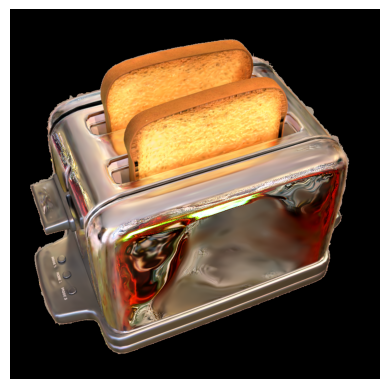

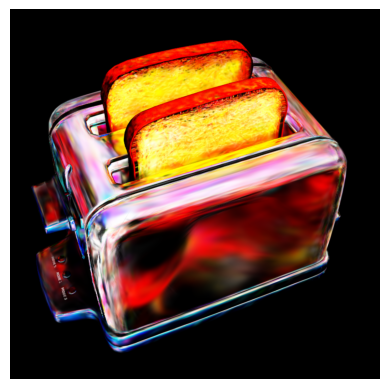

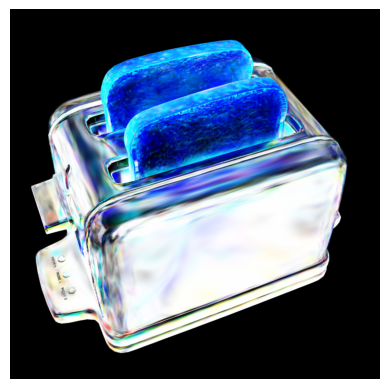

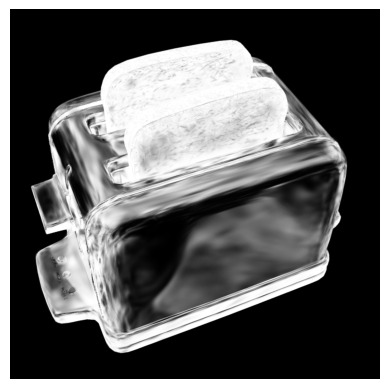

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


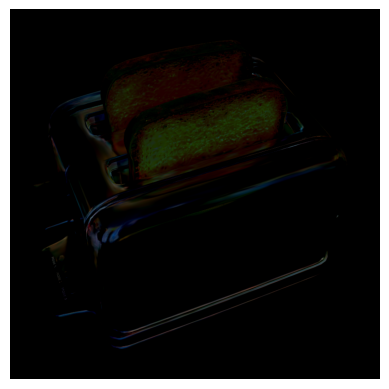

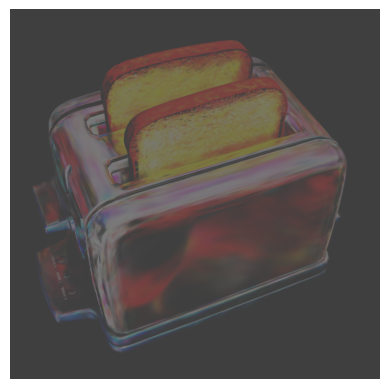

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


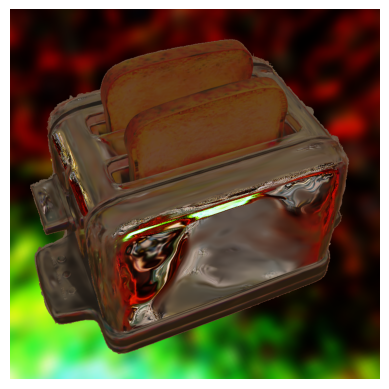

(None, None, None, None, None, None, None)

In [16]:
show_rgb_image(image),show_rgb_image(kd_map),show_rgb_image(ks_map),show_single_channel_image(kr_map[0,:,:][None,:,:]),show_rgb_image(cr_map),show_rgb_image(diffuse_color),show_rgb_image(specular_color)

In [ ]:
rets = pbr_render_gshader(
            viewpoint_camera=viewpoint_cam,
            pc=gaussians,
            light=cubemap,
            pipe=pipe,
            bg_color=background,
            brdf_lut=brdf_lut,
            speed=False)

In [ ]:
image, viewspace_point_tensor, visibility_filter, radii = rets["render"], rets["viewspace_points"], rets["visibility_filter"], rets["radii"]
alpha, rend_normal, dist, surf_depth, normal_from_d = rets["rend_alpha"], rets["rend_normal"], rets["rend_dist"], rets["surf_depth"], rets["surf_normal"]
diffuse_color, specular_color, kd_map, kr_map, ks_map = rets["diffuse_rgb"], rets["specular_rgb"], rets["diffuse"], rets["roughness"], rets["specular"]
cr = rets['color_residul']

In [ ]:
show_rgb_image(image),show_rgb_image(kd_map),show_rgb_image(ks_map),show_single_channel_image(kr_map[0,:,:][None,:,:]),show_rgb_image(cr_map),show_rgb_image(diffuse_color),show_rgb_image(specular_color)

In [ ]:
mask = (rets['rend_normal'] != 0).all(0, keepdim=True)
mask.shape, show_single_channel_image(mask)


## oth00

In [ ]:
viewpoint_cam = viewpoint_stack[80]
cubemap.build_mips()
brdf_lut = get_brdf_lut().cuda()
render_pkg = pbr_render_gshader(
            viewpoint_camera=viewpoint_cam,
            pc=gaussians,
            light=cubemap,
            pipe=pipe,
            bg_color=background,
            brdf_lut=brdf_lut,
            speed=False)



In [ ]:
show_rgb_image(render_pkg['color_residul'])

In [ ]:
show_rgb_image(render_pkg['diffuse_rgb'])

In [ ]:
show_rgb_image(render_pkg['specular_rgb'])

In [ ]:
show_rgb_image(render_pkg["render"])

## Deffered Shading

In [ ]:
kdmap = render_pkg['diffuse']
ksmap = render_pkg['specular_rgb']
kr_map = render_pkg['roughness'][0,:,:][None,:,:]
kdmap.shape, ksmap.shape, kr_map.shape

In [ ]:
normal_map = render_pkg['rend_normal']
normal_map.shape

In [ ]:
mask = (render_pkg["rend_alpha"] >= 0.5).all(0)[None,:,:]
mask.shape, show_single_channel_image(mask)

In [ ]:
import torch.nn.functional as F
canonical_rays = scene.get_canonical_rays()
canonical_rays.shape, canonical_rays
H, W = viewpoint_cam.image_height, viewpoint_cam.image_width
c2w = torch.inverse(viewpoint_cam.world_view_transform.T)  # [4, 4]
view_dirs = -(
    (
        F.normalize(canonical_rays[:, None, :], p=2, dim=-1)
        * c2w[None, :3, :3]
    )  # [HW, 3, 3]
    .sum(dim=-1)
    .reshape(H, W, 3)
)
# canonical_rays是由相机中心指向外部的，所以取负号是wo的方向
view_dirs.shape

In [ ]:
import nvdiffrast.torch as dr
def saturate_dot(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return (a * b).sum(dim=-1, keepdim=True).clamp(min=1e-4, max=1.0)

In [ ]:
((view_dirs * normal_map.permute(1,2,0)).sum(dim=-1)).sum()

In [ ]:
def gshader_deferred_shading(
    light: CubemapLight,
    normals: torch.Tensor,  # [H, W, 3]
    view_dirs: torch.Tensor,  # [H, W, 3]
    kd: torch.Tensor,  # [H, W, 3]
    kr: torch.Tensor,  # [W, 1]
    ks: torch.Tensor,
    brdf_lut: torch.Tensor,
):
    H, W, _ = normals.shape

    nrmvec = normals.reshape(1, H, W, 3)
    view_dirs = view_dirs.reshape(1, H, W, 3)
    diffuse_raw = kd.reshape(1, H, W, 3)
    roughness = kr.reshape(1, H, W, 1)
    spec_col = ks.reshape(1, H, W, 3)
    diff_col = 1.0 - ks

    results = {}
    reflvec = (
        2.0 * (normals * view_dirs).sum(-1, keepdims=True).clamp(min=0.0) * normals - view_dirs
    )  # [1, H, W, 3]

    ambient = dr.texture(light.diffuse[None, ...], nrmvec.contiguous(), filter_mode='linear', boundary_mode='cube')
    specular_linear = ambient * diff_col

    NoV = saturate_dot(nrmvec, view_dirs)  # [1, H, W, 1]
    fg_uv = torch.cat((NoV, roughness), dim=-1)  # [1, H, W, 2]
    fg_lookup = dr.texture(
        brdf_lut,  # [1, 256, 256, 2]
        fg_uv.contiguous(),  # [1, H, W, 2]
        filter_mode="linear",
        boundary_mode="clamp",
    ) 
    miplevel = light.get_mip(roughness)  # [1, H, W, 1]
    spec = dr.texture(light.specular[0][None, ...], 
                          reflvec.contiguous(), 
                          mip=list(m[None, ...] for m in light.specular[1:]), 
                        #   mip_level_bias=miplevel[:,:,None].permute(1,2,0).contiguous(), #[1,1,numG]
                          mip_level_bias=miplevel[..., 0], 
                          filter_mode='linear-mipmap-linear', 
                          boundary_mode='cube') # [1, H, W, 3]

    reflectance = spec_col * fg_lookup[...,0:1] + fg_lookup[...,1:2]
    specular_linear += spec * reflectance

    extras = {"specular": specular_linear}

    diffuse_linear = torch.sigmoid(diffuse_raw - np.log(3.0))
    extras["diffuse"] = diffuse_linear

    rgb = specular_linear + diffuse_linear

    return rgb, extras
    

In [ ]:
viewpoint_cam = viewpoint_stack[80]
cubemap.build_mips()
brdf_lut = get_brdf_lut().cuda()

In [ ]:
cubemap.build_mips()
rgb, extras = gshader_deferred_shading(cubemap, 
                         normal_map.permute(1,2,0).contiguous(), 
                         view_dirs.permute(1,2,0).contiguous(), 
                         kdmap.permute(1,2,0).contiguous(), 
                         kr_map.permute(1,2,0).contiguous(), 
                         ksmap.permute(1,2,0).contiguous(), 
                         brdf_lut)
rgb.shape, extras['specular'].shape, extras['diffuse'].shape

In [ ]:
rgb.max()

In [ ]:
show_rgb_image(rgb.squeeze().permute(2,0,1))

In [ ]:
show_rgb_image(extras['specular'].squeeze().permute(2,0,1))

In [ ]:
show_rgb_image(extras['diffuse'].squeeze().permute(2,0,1))

In [ ]:
cr_map = render_pkg['color_residul']
show_rgb_image(cr_map)

In [ ]:
import nvdiffrast.torch as dr
def saturate_dot(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return (a * b).sum(dim=-1, keepdim=True).clamp(min=1e-4, max=1.0)

def pbr_shading(
    light: CubemapLight,
    normals: torch.Tensor,  # [H, W, 3]
    view_dirs: torch.Tensor,  # [H, W, 3]
    mask: torch.Tensor,  # [H, W, 1]
    albedo: torch.Tensor,  # [H, W, 3]
    roughness: torch.Tensor,  # [H, W, 1]
    metallic: torch.Tensor,
    brdf_lut: torch.Tensor,
    background: torch.Tensor,
):
    H, W, _ = normals.shape
    if background is None:
        background = torch.zeros_like(normals)  # [H, W, 3]

    # prepare
    normals = normals.reshape(1, H, W, 3)
    view_dirs = view_dirs.reshape(1, H, W, 3)
    albedo = albedo.reshape(1, H, W, 3)
    roughness = roughness.reshape(1, H, W, 1)

    results = {}
    # prepare
    ref_dirs = (
        2.0 * (normals * view_dirs).sum(-1, keepdims=True).clamp(min=0.0) * normals - view_dirs
    )  # [1, H, W, 3]

    # Diffuse lookup
    diffuse_light = dr.texture(
        light.diffuse[None, ...],  # [1, 6, 16, 16, 3]
        normals.contiguous(),  # [1, H, W, 3]
        filter_mode="linear",
        boundary_mode="cube",
    )  # [1, H, W, 3]

    results["diffuse_light"] = diffuse_light[0]
    diffuse_rgb = diffuse_light * albedo  # [1, H, W, 3]

    # specular
    NoV = saturate_dot(normals, view_dirs)  # [1, H, W, 1]
    fg_uv = torch.cat((NoV, roughness), dim=-1)  # [1, H, W, 2]
    fg_lookup = dr.texture(
        brdf_lut,  # [1, 256, 256, 2]
        fg_uv.contiguous(),  # [1, H, W, 2]
        filter_mode="linear",
        boundary_mode="clamp",
    )  # [1, H, W, 2]

    # Roughness adjusted specular env lookup
    miplevel = light.get_mip(roughness)  # [1, H, W, 1]
    spec = dr.texture(
        light.specular[0][None, ...],  # [1, 6, env_res, env_res, 3]
        ref_dirs.contiguous(),  # [1, H, W, 3]
        mip=list(m[None, ...] for m in light.specular[1:]),
        mip_level_bias=miplevel[..., 0],  # [1, H, W]
        filter_mode="linear-mipmap-linear",
        boundary_mode="cube",
    )  # [1, H, W, 3]

    # Compute aggregate lighting
    if metallic is None:
        F0 = torch.ones_like(albedo) * 0.04  # [1, H, W, 3]
    else:
        F0 = (1.0 - metallic) * 0.04 + albedo * metallic
    reflectance = F0 * fg_lookup[..., 0:1] + fg_lookup[..., 1:2]  # [1, H, W, 3]
    specular_rgb = spec * reflectance  # [1, H, W, 3]

    render_rgb = diffuse_rgb + specular_rgb  # [1, H, W, 3]

    render_rgb = render_rgb.squeeze()  # [H, W, 3]

    
    render_rgb = render_rgb.clamp(min=0.0, max=1.0)
    render_rgb = torch.where(mask, render_rgb, background)

    results.update(
        {
            "render_rgb": render_rgb,
            "diffuse_rgb": diffuse_rgb.squeeze(),
            "specular_rgb": specular_rgb.squeeze(),
        }
    )

    return results

In [ ]:
image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

alpha, rend_normal, dist, surf_depth, normal_from_d = render_pkg["rend_alpha"], render_pkg["rend_normal"], render_pkg["rend_dist"], render_pkg["surf_depth"], render_pkg["surf_normal"]

diffuse_rgb, specular_rgb, albedo, roughness, metallic = render_pkg["diffuse_rgb"], render_pkg["specular_rgb"], render_pkg["albedo"], render_pkg["roughness"], render_pkg["metallic"]
            

In [ ]:
normal_mask = (rend_normal != 0).all(0, keepdim=True)
normal_mask.shape, show_single_channel_image(normal_mask)

In [ ]:
mask = (render_pkg["rend_alpha"] != 0).all(0)[None,:,:]
mask.shape, show_single_channel_image(mask)


In [ ]:
albedo.shape, roughness.shape, metallic.shape, alpha.shape 

In [ ]:
show_single_channel_image(alpha)

In [ ]:
mask = (render_pkg["rend_alpha"] >= 0.5).all(0)[None,:,:]
mask.shape, show_single_channel_image(mask)

In [ ]:
canonical_rays = scene.get_canonical_rays()
canonical_rays.shape, canonical_rays

In [ ]:
import torch.nn.functional as F
canonical_rays = scene.get_canonical_rays()
canonical_rays.shape, canonical_rays
H, W = viewpoint_cam.image_height, viewpoint_cam.image_width
c2w = torch.inverse(viewpoint_cam.world_view_transform.T)  # [4, 4]
view_dirs = -(
    (
        F.normalize(canonical_rays[:, None, :], p=2, dim=-1)
        * c2w[None, :3, :3]
    )  # [HW, 3, 3]
    .sum(dim=-1)
    .reshape(H, W, 3)
) 
view_dirs


In [ ]:
pbr_result = pbr_shading(
                light=cubemap,
                normals=rend_normal.permute(1, 2, 0).detach(),  # [H, W, 3]
                view_dirs=view_dirs,
                mask=normal_mask.permute(1, 2, 0),  # [H, W, 1]
                albedo=albedo.permute(1, 2, 0),  # [H, W, 3]
                roughness=roughness[0,:,:][None,:,:].permute(1, 2, 0),  # [H, W, 1]
                metallic=metallic[0,:,:][None,:,:].permute(1, 2, 0),  # [H, W, 1]
                brdf_lut=brdf_lut,
                background=background,
            )

In [ ]:
img_01 = pbr_result["render_rgb"]
diffuse_01 = pbr_result["diffuse_rgb"]
specular_01 = pbr_result["specular_rgb"]

show_rgb_image(diffuse_01.permute(2, 0, 1))
show_rgb_image(specular_01.permute(2, 0, 1))
show_rgb_image(img_01.permute(2, 0, 1))
# img_01.shape

In [ ]:
img00 = image
difuse00 = diffuse_rgb
specular00 = specular_rgb
show_rgb_image(difuse00)
show_rgb_image(specular00)
show_rgb_image(img00)

## others

In [ ]:
img_01 = img_01.permute(2, 0, 1)
img_01.shape, img00.shape

In [ ]:
from utils.loss_utils import l1_loss
gt_image = viewpoint_cam.original_image.cuda()

loss01 = l1_loss(img_01, gt_image)
loss00 = l1_loss(img00, gt_image)
loss01, loss00


In [ ]:
gaussians._opacity.grad[12]

In [ ]:
gaussians.training_setup(op)


In [ ]:
gaussians.optimizer.zero_grad()

In [ ]:
loss01.backward()
gaussians._opacity.grad[12]




In [ ]:
import torch
a = torch.zeros((12,3,16))
a[:,3:,1:]

## test for Gshader residual color